In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json
from typing import Union, List, Literal
import matplotlib.patches as mpatches
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
import matplotlib.ticker as ticker
import plotly.express as px

sns.set_palette("pastel")


## 1. Laden der Datensätze

In der folgenden statistische Analyse werden wir die aufbereiteten Ergebnisse der Umfrage verwenden. Zur vereinfachten Verarbeitung der Daten wurden die Fragen auf ihre Codes reduziert und die Antwortmöglichkeiten in numerischer Darstellung verwendet. 

### 1.1 Utility Functions

Die Utility Funktionen werden verwendet, um die Fragen-Codes wieder in Text und die numerischen Antwortmöglichkeiten in den zugehörigen Text umzuwandeln.

In [2]:
def get_answer_text(question_code: str, answer_res: Union[float, int, str] = None):
    if isinstance(answer_res, str):
        _res = answer_res
    else:
        _res = int(answer_res) if answer_res != 0 else '<leer>'
    t_code = df_code[df_code["Variable"] == question_code]
    question_type = t_code["Fragetyp"].values[0]
    assert (answer_res is not None and question_type != 'Offene Frage') or (answer_res is None and question_type == 'Offene Frage'), f"Ungültige Antwortmöglichkeit für Fragentyp {question_type}"
    answer_dict = t_code["Werte"].values[0]
    out = answer_dict[str(_res)] if answer_res is not None else answer_dict
    return out

In [3]:
def add_new_line(i_str: str):
    lines = i_str.split(" ")
    print(lines)
    if len(lines) > 1:
        return " ".join(lines[:3]) + "\n" + " ".join(lines[3:])
    else:
        return lines[0]

In [4]:
def get_question_text(question_code: str):
    return df_code[df_code["Variable"] == question_code]["Fragetext"].values[0]

### 1.2 Daten laden

In [5]:
results_pre_processed = pq.read_table('results_preprocessed.parquet')

In [6]:
df_yz = results_pre_processed.to_pandas()

In [7]:
df_yz.head()

,Bogen,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,...,60371647,60371648,60371649,60371650,60371651,60371652,60371653,60371654,Zeitstempel,Datensatz-Ursprung
0,1,4,4,5,4,4,5,5,4,4,...,2,5,2,2.0,6,1,1.0,3.0,02.07.2023 um 17:44:14,O
1,2,4,5,5,5,5,4,5,4,4,...,1,5,1,2.0,6,1,1.0,2.0,02.07.2023 um 17:50:50,O
2,3,4,2,5,4,5,4,5,2,4,...,2,3,1,1.0,4,1,1.0,3.0,02.07.2023 um 18:55:10,M
3,4,5,4,5,4,4,4,4,2,3,...,1,5,1,2.0,4,1,2.0,3.0,02.07.2023 um 19:00:41,M
4,5,5,4,5,3,5,5,4,3,4,...,1,4,1,2.0,5,1,1.0,3.0,02.07.2023 um 19:03:32,M


Die aufgestellten Hypothesen beinhalten Aussagen zu gewissen Fragen Clustern. Die Ergebnisse der Cluster ergeben sich durch die Berechung der Mittelwerte über die zugrunde liegenden Fragen. Für die weiteren Analysen werden diese Cluster zu unserem Datensatz hinzugefügt.

Bsp.:
Cluster h11

zugehörige Fragen Codes: 60371624, 60371628, 60371631, 60371638

Beobachtung Cluster h11 &wedgeq; Mittelwert(Beobachtung 60371624, Beobachtung 60371628, Beobachtung 60371631, Beobachtung 60371638)

In [13]:
df_yz["h11"] = df_yz[["60371624","60371628", "60371631", "60371638"]].mean(axis=1)
df_yz["h11_median"] = df_yz[["60371624", "60371628", "60371631", "60371638"]].median(axis=1)

In [14]:
df_yz["h12"] = df_yz[["60371632","60371648"]].mean(axis=1)
df_yz["h13"] = df_yz[["60371625","60371626", "60371628", "60371630"]].mean(axis=1)

In [15]:
df_yz["h11_median"]

0      4.0
1      5.0
2      4.5
3      4.0
4      4.0
      ... 
222    4.0
223    4.0
224    4.0
225    4.0
226    4.0
Name: h11_median, Length: 200, dtype: float64

### 1.3 Laden der Frage-Codes

Zur besseren Verarbeitung der Datensätze werden die zugehörigen Codes der Fragen geladen und verwendet. 

In [16]:
with open('code.json', 'r') as f:
  code_data = json.load(f)

In [17]:
df_code = pd.DataFrame(code_data)
codes = df_code["Variable"].tolist()

### 1.2 Gliederung der Fragetypen

Die Umfrage enthält 3 Fragetypen.
- Skalafragen - Antwortmöglichkeiten werden mittels kategorischen numerischen Werten auf einer Ordinalskala dargestellt.
- 1 aus n - Antwortmöglichkeiten werden mittels kategorischen numerischen Werten auf einer Nominalskala dargestellt.
- Offene Frage - Antwort besteht aus einem Freitext

In [18]:
skala_ids = df_code[df_code["Fragetyp"] == "Skalafrage"]["Variable"].tolist()
one_of_n_ids = df_code[df_code["Fragetyp"] == "1 aus n"]["Variable"].tolist()
numeric_ids = skala_ids + one_of_n_ids
open_q_ids = df_code[df_code["Fragetyp"] == "Offene Frage"]["Variable"].tolist()

Neben den fachlichen Fragen der Umfrage, gibt es auch Fragetypen, welche zur Klassifierung der Umfrage Ergebnisse dienen.
- Bitte kreuze an, welcher Generation du zugehörig bist
- Welchem Geschlecht fühlst du dich zugehörig?
- Bitte wähle deinen höchsten formalen Bildungsabschluss aus:
- Bist du derzeit berufstätig?
- In welcher Beschäftigungsform befindest du dich?
- In welchem Wirtschaftssektor bist du beschäftigt?

In [19]:
generation_col = '60371649'
gender_col = '60371650'
academic_col = '60371651'
working_col = '60371652'
work_form_col = '60371653'
economic_sector_col = '60371654'

Zur weiteren Einschränkung der Fragetypen, können wir die Überschneidungen zwischen "fachlichen" Fragen und "gruppierenden" Fragen bestimmen und für weitere mögliche Auswertungen zwischen den beiden Typen unterscheiden.

In [20]:
skala_fach_ids = [x for x in skala_ids if int(x) <= 60371648]
one_of_n_fach_ids = [x for x in one_of_n_ids if int(x) <= 60371648]
num_fach_cols = skala_fach_ids + one_of_n_fach_ids

print(skala_fach_ids)
print(one_of_n_fach_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609', '60371615', '60371616', '60371617', '60371618', '60371619', '60371620', '60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']
['60371613', '60371614']


Darüberhinaus gliedert sich die Umfrage in 2 Fragen-Cluster: 
- Fragen rund um die Erwartungen der Probanten an einen Arbeitsplatz sowie Arbeitgebermerkmalen
- Fragen an persönliche Wertevorstellungen der Probanten 

In [21]:
erwartungen_ids = [x for x in codes if 60371597 <= int(x) and int(x) <= 60371609]
macht_erwartung_ids = ["60371616", "60371599", "60371597", "60371598", "60371603"]
ag_merkmale_ids = [x for x in codes if 60371615 <= int(x) and int(x) <= 60371620]
print(erwartungen_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609']


In [22]:
werte_ids = [x for x in codes if 60371624 <= int(x) and int(x) <= 60371648]
familie_ids = ["60371641", "60371640", "60371634", "60371635", "60371638", "60371645"]
leben_ids = ["60371643", "60371646", "60371644", "60371642", "60371647", "60371648"]
tugend_ids = ["60371624", "60371628", "60371631", "60371638"]
toleranz_ids = ["60371633", "60371629", "60371632", "60371648", "60371627"]
macht_ids = ["60371626", "60371625", "60371630", "60371642"]
tradition_ids = ["60371637", "60371639", "60371636"]

print(werte_ids)

['60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']


### 2. Statistische Verfahren

#### 2.0 Cronbachs Alpha

Cronbachs Alpha (auch Cronbachs α oder einfach nur α) ist ein Maß für die interne Konsistenz einer Skala. Cronbachs Alpha sagt aus, wie gut eine Gruppe von Variablen oder Items ein einziges, unidimensionales latentes Konstrukt misst. Im Prinzip ist Cronbachs Alpha nicht viel mehr als die Korrelation zwischen den Antworten in einem Fragebogen. Cronbachs Alpha kann, wie der Korrelationskoeffizient auch, Werte zwischen -1 und 1 annehmen.

Der Vorteil von Cronbachs Alpha ist, dass es uns ein einziges, einfach zu interpretierendes Maß für die Stärke der Reliabilität gibt. Auch wenn wir im Verlauf dieses Tutorials von Items sprechen werden, kann der Begriff durch andere ersetzt werden – beispielsweise Fragen, Beurteiler, Indikatoren. Cronbachs Alpha beantwortet damit die Frage „In wie weit messen wir dasselbe?“.

In [23]:
def cronbach_alpha(data):
    # Transform the data frame into a correlation matrix
    df_corr = data.corr()
    
    # Calculate N
    # The number of variables is equal to the number of columns in the dataframe
    N = data.shape[1]
    
    # Calculate r
    # For this, we'll loop through all the columns and append every
    # relevant correlation to an array called 'r_s'. Then, we'll
    # calculate the mean of 'r_s'.
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [24]:
cronbach_alpha(df_yz[skala_ids])

0.7910335324548505

#### 2.1 Korrelationskoeffizienten, Rangkoeffizenten, ...

**Spearmann**

Die Rangkorrelationsanalyse nach Spearman berechnet den linearen Zusammenhang zweier mindestens **ordinalskalierter Variablen**.
Da stets der Zusammenhang zwischen zwei Variablen untersucht wird, wird von einem "bivariaten Zusammenhang" gesprochen.

Zwei Variablen hängen dann linear zusammen, wenn sie linear miteinander variieren (also kovariieren). Sie können dies in unterschiedlicher Weise tun:

- Gleichsinnige oder positive Korrelation: Hohe (tiefe) Ausprägungen der einen Variablen gehen mit hohen (tiefen) Ausprägungen der zweiten Variablen einher (Abbildung 1: oben links). Zum Beispiel: Je besser die Mathematiknote eines Lernenden, desto zufriedener ist er mit seiner Leistung. Je schlechter die Mathematiknote, desto geringer ist die Zufriedenheit.
- Gegenläufige oder negative Korrelation: Hohe Werte der einen Variablen gehen mit tiefen Werten der anderen einher (Abbildung 1: oben rechts). Zum Beispiel: Je höher das Medianeinkommen eines Landes ist, desto tiefer ist die Arbeitslosigkeit. Je tiefer das Medianeinkommen ist, desto höher ist die Arbeitslosigkeit.

Auch nicht-lineare Zusammenhänge sind möglich, wie beispielsweise eine u-förmige (Abbildung 1: unten rechts) oder umgekehrt u-förmige Kovariation. Eine Rangkorrelationsanalyse ist jedoch nur bei linearen Zusammenhängen anwendbar.

In [25]:
spearman_korr = df_yz[skala_ids].corr(method="spearman")
spearman_korr_y = df_yz[df_yz[generation_col] == 1][skala_ids].corr(method="spearman")
spearman_korr_z = df_yz[df_yz[generation_col] == 2][skala_ids].corr(method="spearman")

In [26]:
spearman_korr

,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,60371606,...,60371639,60371640,60371641,60371642,60371643,60371644,60371645,60371646,60371647,60371648
60371597,1.000000,0.276412,0.025229,0.006439,-0.129484,0.020613,0.047409,-0.093777,-0.193113,-0.143939,...,-0.008241,0.064113,0.032933,-0.054857,0.161220,-0.059496,0.111857,-0.107585,-0.024552,-0.182292
60371598,0.276412,1.000000,-0.081075,0.185907,0.045104,0.249228,0.143051,0.069741,0.214402,0.121701,...,-0.027115,0.062010,0.077564,0.112382,0.163440,-0.049497,0.167651,0.042358,0.074200,0.082583
60371599,0.025229,-0.081075,1.000000,0.098997,0.206047,0.170971,0.115829,0.243287,-0.026389,0.148967,...,0.127662,0.172854,0.121153,0.063137,0.177923,0.185171,0.098127,0.080503,0.232902,0.014542
60371600,0.006439,0.185907,0.098997,1.000000,0.250658,0.241040,0.166049,0.524322,0.242833,0.263982,...,-0.126450,0.001511,0.103511,0.458532,0.070188,0.071005,0.046826,0.088723,0.075832,0.237916
60371601,-0.129484,0.045104,0.206047,0.250658,1.000000,0.259595,0.179875,0.298159,0.254683,0.296916,...,-0.037025,0.052201,0.161159,0.185978,0.098124,0.276395,0.141143,0.103458,-0.009369,0.174937
60371602,0.020613,0.249228,0.170971,0.241040,0.259595,1.000000,0.432410,0.307854,0.381147,0.350367,...,0.046207,-0.043517,0.104037,0.159694,0.216355,0.110315,0.160728,0.184422,0.156882,0.139863
60371603,0.047409,0.143051,0.115829,0.166049,0.179875,0.432410,1.000000,0.177339,0.274068,0.251195,...,0.072619,0.043066,0.168489,0.101678,0.200144,0.081354,0.220751,0.234001,0.048411,0.120434
60371604,-0.093777,0.069741,0.243287,0.524322,0.298159,0.307854,0.177339,1.000000,0.268580,0.463809,...,0.064370,0.013395,0.100624,0.228102,0.090458,0.101778,0.111628,0.184298,0.290473,0.271847
60371605,-0.193113,0.214402,-0.026389,0.242833,0.254683,0.381147,0.274068,0.268580,1.000000,0.367397,...,0.025814,0.049829,0.111692,0.141533,-0.000595,0.161974,0.074928,0.194273,0.130476,0.204204
60371606,-0.143939,0.121701,0.148967,0.263982,0.296916,0.350367,0.251195,0.463809,0.367397,1.000000,...,0.086733,0.054062,0.150113,0.190788,0.236786,0.168656,0.056321,0.275681,0.203040,0.379904


In [27]:
werte_korr = spearman_korr[erwartungen_ids + ag_merkmale_ids].filter(items=werte_ids, axis=0)
werte_korr_y = spearman_korr_y[erwartungen_ids + ag_merkmale_ids].filter(items=werte_ids, axis=0)
werte_korr_z = spearman_korr_z[erwartungen_ids + ag_merkmale_ids].filter(items=werte_ids, axis=0)

In [28]:
display(werte_korr.idxmax())
display(werte_korr.max())

60371597    60371625
60371598    60371631
60371599    60371628
60371600    60371642
60371601    60371644
60371602    60371631
60371603    60371631
60371604    60371629
60371605    60371627
60371606    60371629
60371607    60371627
60371608    60371634
60371609    60371646
60371615    60371625
60371616    60371628
60371617    60371624
60371618    60371631
60371619    60371629
60371620    60371646
dtype: object

60371597    0.306320
60371598    0.359060
60371599    0.474472
60371600    0.458532
60371601    0.276395
60371602    0.406941
60371603    0.363915
60371604    0.508836
60371605    0.501389
60371606    0.440943
60371607    0.392855
60371608    0.297305
60371609    0.126825
60371615    0.241963
60371616    0.218893
60371617    0.144316
60371618    0.259274
60371619    0.265171
60371620    0.473082
dtype: float64

In [29]:
macht_korr = spearman_korr[macht_erwartung_ids].filter(items=macht_ids, axis=0)
macht_korr_y = spearman_korr_y[macht_erwartung_ids].filter(items=macht_ids, axis=0)
macht_korr_z = spearman_korr_z[macht_erwartung_ids].filter(items=macht_ids, axis=0)

In [30]:
max_korr_z = werte_korr_z.filter(items=werte_korr_y.idxmax().values, axis=0)
min_korr_z = werte_korr_z.filter(items=werte_korr_y.idxmin().values, axis=0)

In [31]:
display(max_korr_z)

,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,60371606,60371607,60371608,60371609,60371615,60371616,60371617,60371618,60371619,60371620
60371625,0.297062,0.330340,0.036711,-0.115540,0.038882,0.280914,0.260197,-0.140138,0.132691,-0.027810,0.104889,-0.007044,0.188430,0.171659,0.256160,0.065426,0.103256,-0.080301,0.003975
60371626,0.236338,0.371871,-0.004952,0.008639,0.032211,0.053740,0.212421,-0.042921,0.209929,0.020596,-0.061618,-0.079926,0.148362,0.223725,0.215991,-0.160999,0.123752,-0.000576,0.064602
60371628,0.121604,-0.015847,0.408845,-0.066544,0.028716,-0.037129,0.102373,0.189514,-0.008233,-0.029445,-0.125341,0.027602,0.028071,-0.055779,0.198802,0.176421,-0.053743,0.230315,-0.048633
60371642,-0.128937,0.011741,0.052309,0.465056,0.173934,0.181341,0.102012,0.168265,0.184469,0.122870,0.072920,0.126298,0.002198,-0.183927,-0.236478,0.078756,0.082482,0.106394,0.096342
60371644,0.026676,-0.112945,0.269089,0.122234,0.121712,0.136465,0.205390,-0.014989,0.122610,0.115334,0.078113,0.095840,0.217242,0.016303,0.044937,0.092337,0.167517,0.250603,0.034231
60371631,0.185620,0.385452,0.150825,0.040252,0.148956,0.341293,0.327438,0.002856,0.302735,0.093485,0.144620,0.031556,0.091469,-0.009530,0.259324,0.014130,0.151561,0.198696,0.002992
60371631,0.185620,0.385452,0.150825,0.040252,0.148956,0.341293,0.327438,0.002856,0.302735,0.093485,0.144620,0.031556,0.091469,-0.009530,0.259324,0.014130,0.151561,0.198696,0.002992
60371629,-0.098960,-0.104232,0.241091,0.248133,0.107176,0.115769,0.046901,0.493699,0.269763,0.396640,0.172186,0.156506,-0.279376,-0.245695,-0.041168,0.049722,-0.118453,0.312439,0.307859
60371627,-0.136039,-0.025427,-0.085270,0.120818,0.121251,0.290298,0.247681,0.073217,0.499783,0.327288,0.306937,-0.033232,-0.138834,0.022640,0.067259,-0.021127,0.050179,0.120289,0.240107
60371629,-0.098960,-0.104232,0.241091,0.248133,0.107176,0.115769,0.046901,0.493699,0.269763,0.396640,0.172186,0.156506,-0.279376,-0.245695,-0.041168,0.049722,-0.118453,0.312439,0.307859


In [32]:
display(min_korr_z)

,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,60371606,60371607,60371608,60371609,60371615,60371616,60371617,60371618,60371619,60371620
60371629,-0.098960,-0.104232,0.241091,0.248133,0.107176,0.115769,0.046901,0.493699,0.269763,0.396640,0.172186,0.156506,-0.279376,-0.245695,-0.041168,0.049722,-0.118453,0.312439,0.307859
60371636,0.076383,-0.306476,-0.112708,-0.069170,-0.107486,-0.136597,0.004564,0.006060,-0.209279,-0.009763,-0.088152,-0.071016,-0.020283,-0.001327,-0.098815,-0.064535,-0.051618,-0.161733,-0.071744
60371633,0.002263,0.111126,0.041988,0.076203,0.030595,0.009147,0.182939,0.059300,0.215944,0.203558,0.115738,0.111285,0.059008,-0.000301,0.090731,0.007481,0.153951,0.179586,0.254653
60371638,-0.008239,-0.070294,0.288953,0.163382,-0.004634,-0.015574,-0.037670,0.148751,-0.045362,0.019495,-0.007069,0.125227,-0.004471,-0.021046,-0.078527,0.194461,-0.227774,0.170862,0.001299
60371637,0.027681,-0.173845,0.046151,-0.043315,0.039014,-0.080035,0.045086,0.024723,-0.072472,0.154468,0.043210,0.052733,-0.037457,0.052018,-0.043962,0.008334,0.055306,-0.115227,0.057937
60371640,0.061954,0.071538,0.165107,0.086045,0.052442,0.054578,0.104743,-0.031785,0.148649,0.086906,0.097502,0.053877,0.025179,-0.021143,0.033401,0.169425,-0.029412,0.100671,0.049049
60371625,0.297062,0.330340,0.036711,-0.115540,0.038882,0.280914,0.260197,-0.140138,0.132691,-0.027810,0.104889,-0.007044,0.188430,0.171659,0.256160,0.065426,0.103256,-0.080301,0.003975
60371625,0.297062,0.330340,0.036711,-0.115540,0.038882,0.280914,0.260197,-0.140138,0.132691,-0.027810,0.104889,-0.007044,0.188430,0.171659,0.256160,0.065426,0.103256,-0.080301,0.003975
60371634,0.123094,0.113525,0.133022,0.212414,0.339619,0.150031,0.137821,0.134176,-0.017551,0.178297,0.123693,0.318984,0.046443,-0.098506,-0.064121,0.091317,0.086721,0.063612,0.036438
60371625,0.297062,0.330340,0.036711,-0.115540,0.038882,0.280914,0.260197,-0.140138,0.132691,-0.027810,0.104889,-0.007044,0.188430,0.171659,0.256160,0.065426,0.103256,-0.080301,0.003975


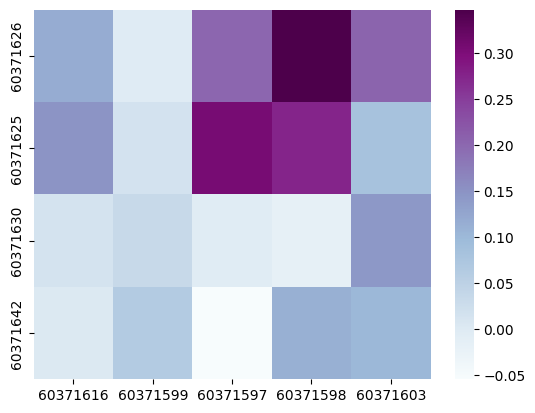

In [33]:
sns.heatmap(macht_korr, cmap="BuPu");

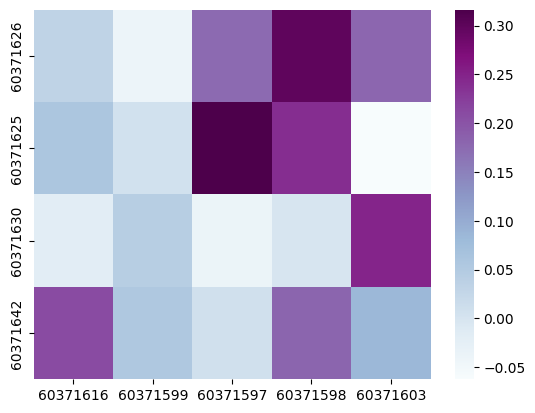

In [34]:
sns.heatmap(macht_korr_y, cmap="BuPu");

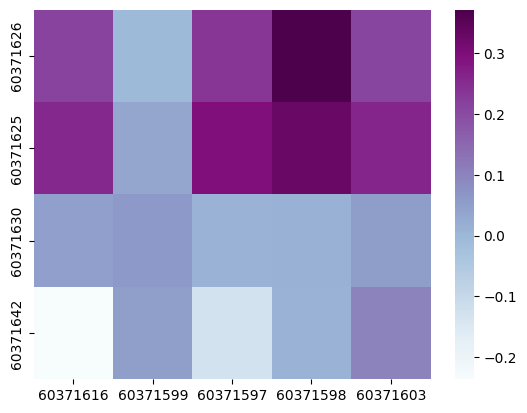

In [35]:
sns.heatmap(macht_korr_z, cmap="BuPu");

In [36]:
leben_korr = spearman_korr[erwartungen_ids + ag_merkmale_ids].filter(items=leben_ids, axis=0)
leben_korr_y = spearman_korr_y[erwartungen_ids + ag_merkmale_ids].filter(items=leben_ids, axis=0)
leben_korr_z = spearman_korr_z[erwartungen_ids + ag_merkmale_ids].filter(items=leben_ids, axis=0)

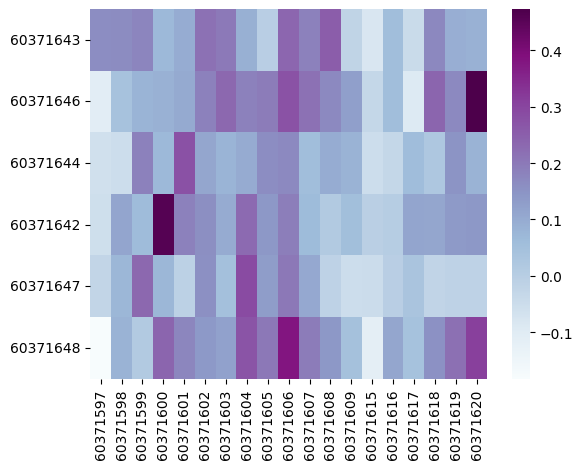

In [37]:
sns.heatmap(leben_korr, cmap="BuPu");

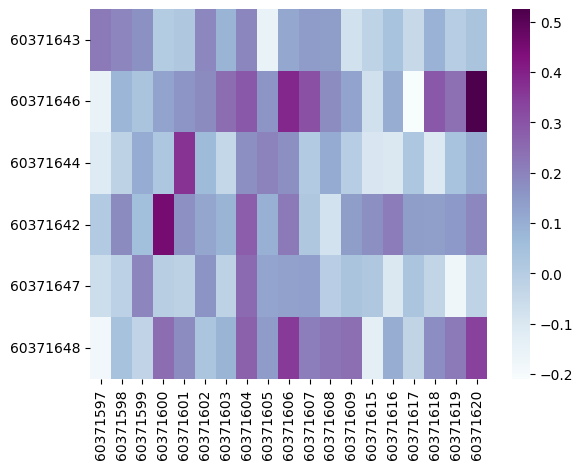

In [38]:
sns.heatmap(leben_korr_y, cmap="BuPu");

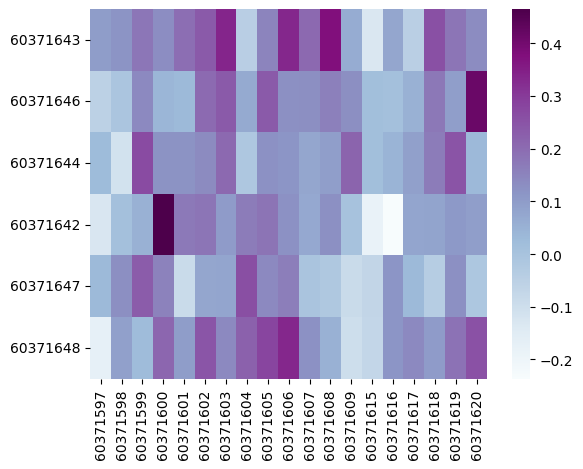

In [39]:
sns.heatmap(leben_korr_z, cmap="BuPu");

#### 2.2 Hypothesentests

**Student's T-Test**


- **Unabhängigkeit der Messungen.** Dies ist eine der wichtigsten Voraussetzungen der ungepaarten t-Tests. Messungen sind dann unabhängig, wenn der Messwert einer Gruppe nicht abhängt oder beeinflusst wird durch den Messwert aus einer anderen Gruppe. Gewinnt man seine Messdaten von Menschen, ist diese Bedingung meistens bereits erfüllt, wenn kein Teilnehmer aus einer Gruppe auch in einer anderen Gruppe vorkommt. Daher befinden sich in jeder Gruppe unterschiedliche Personen. Auch wenn man Personen nach Geschlecht, Alter oder Bildungsabschluss aufteilt, wären die Personen in jeder Gruppe andere. Hat man allerdings ein Versuchsdesign, bei dem dieselbe Person mehrmals gemessen wurde, sollte man eher zu einem gepaarten t-Test greifen.
- **Die abhängige Variable soll mindestens intervallskaliert sein.** Das Skalenniveau ist wichtig, da wir die Differenz zwischen beiden Gruppen bilden – eine mathematische Operation, die erst ab einer intervallskalierten Variablen durchgeführt werden darf.
- **Die unabhängige Variable ist nominalskaliert und hat zwei Ausprägungen.** Unsere unabhängige Variable muss kategorial sein, daher nominalskaliert und muss zwei Ausprägungen haben. Die beiden Ausprägungen beziehen sich auf die beiden Gruppen, die wir vergleichen und sind oft, aber nicht zwangsläufig, Messzeitpunkte (z.B. Messzeitpunkt #1 verglichen mit Messzeitpunkt #2).
- **Ausreißer.** Es sollten keine Ausreißer in den Daten sein, da die meisten parametrischen Statistiken nur wenig robust gegenüber Ausreißern sind, also Werte die sich weit entfernt von der Masse der anderen Werten befinden. Ein einziger Ausreißer kann bereits ein sonst signifikantes Ergebnis nicht signifikant werden lassen oder aber auch ein sonst nicht signifikantes Ergebnis signifikant (was in der Regel seltener vorkommt). Daher ist es besonders wichtig, die Daten auf Ausreißer zu überprüfen.
- **Normalverteilung.** Als parametrisches Verfahren liefert der ungepaarte t-Test die am besten zu interpretierenden Ergebnisse, wenn beide Gruppen etwa normalverteilt sind. Allerdings gibt es bei dieser Regel Ausnahmen und Abschwächungen. Viele Textbücher empfehlen zwar sofort den Einsatz anderer statistischer Verfahren, sollte diese Voraussetzung nicht erfüllt sein, jüngere Simulationsstudien zeigen hier allerdings, dass der ungepaarte t-Test robust gegen die Verletzung dieser Annahme ist.
- **Die Varianzen in jeder Gruppe sollten (etwa) gleich sein (Homoskedastizität).** Die Varianz spielt bei dem ungepaarten t-Test eine große Rolle. Liegen die Varianzen der einzelnen Gruppe zu weit voneinander entfernt, erhöht sich die Wahrscheinlichkeit, einen Fehler erster Art zu begehen. Allerdings gibt es auch hier Korrekturmöglichkeiten, sollte diese Voraussetzung nicht erfüllt sein, die wir auch noch besprechen werden.


#### Prüfen der Varianzhomogenität

**Levene-Test**

Ein Levene-Test (in Form eines F-Test) prüft basierend auf der F-Verteilung, ob zwischen zwei oder mehr Gruppen unterschiedliche Varianzen vorliegen oder Varianzgleichheit zwischen ihnen existiert. Hierbei sollten die Gruppen keine stark unterschiedlichen Größen haben, da die F-Statistik für den Test sonst verzerrt ist. Die Nullhypothese lautet, dass sie gleiche Varianzen besitzen. Die Alternativhypothese demzufolge entsprechend, dass sie unterschiedliche Varianzen besitzen.

Wenn der p-Wert für den Levene-Test größer als 0,05 ist, dann unterscheiden sich die Varianzen nicht signifikant voneinander (d. h., die Homogenitätsannahme der Varianz ist erfüllt). Wenn der p-Wert für den Levene-Test kleiner als .05 ist, gibt es einen signifikanten Unterschied zwischen den Varianzen.

- H0: Gruppen haben gleiche Varianzen
- H1: Gruppen haben unterschiedliche Varianzen

Wichtig ist zu beachten, dass die Mittelwerte der einzelnen Gruppen keinen Einfluss auf das Ergebnis haben, diese können sich unterscheiden. Ein großer Vorteil des Levene-Tests ist, dass er gegenüber Verletzungen der Normalverteilung sehr stabil ist. Daher wird der Levene-Test in vielen Statistik Programmen verwendet. 

In [40]:
def get_levene_df(input_df: pd.DataFrame, question_ids: List[str]):
    out_df = pd.DataFrame(columns=["question_id", "statistic", "pvalue"])
    for question_code in question_ids:
        gen_y = input_df[input_df[generation_col] == 1][question_code] 
        gen_z = input_df[input_df[generation_col] == 2][question_code]
        
        l_stat = stats.levene(gen_y, gen_z, center='median')
        
        tmp = pd.DataFrame([{"question_id": question_code, "statistic": l_stat.statistic, "pvalue": l_stat.pvalue}])
        
        out_df = pd.concat([out_df, tmp], ignore_index=True)
    return out_df     

In [41]:
get_levene_df(df_yz, skala_ids)

,question_id,statistic,pvalue
0,60371597,0.560492,0.454950
1,60371598,1.096883,0.296228
2,60371599,1.994037,0.159489
3,60371600,1.410695,0.236364
4,60371601,9.093031,0.002902
5,60371602,0.241841,0.623424
6,60371603,0.865498,0.353338
7,60371604,0.108576,0.742119
8,60371605,0.569039,0.451537
9,60371606,3.439226,0.065153


In [42]:
# function for calculating the t-test for two independent samples
def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = np.mean(data1), np.mean(data2)
    n1, n2 = len(data1), len(data2)

    var1, var2= np.var(data1, ddof=1), np.var(data2, ddof=1)
    
    # pooled sample variance
    var = ( ((n1-1)*var1) + ((n2-1)*var2) ) / (n1+n2-2)
    # standard error
    std_error = np.sqrt(var * (1.0 / n1 + 1.0 / n2))
    
    # calculate standard errors
    #se1, se2 = stats.sem(data1), stats.sem(data2)
    # standard error on the difference between the samples
    #sed = math.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = abs(mean1 - mean2) / std_error
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = stats.t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - stats.t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

In [43]:
def get_student_t(input_df: pd.DataFrame, question_ids: List[str], alpha: float):
    out_df = pd.DataFrame(columns=["question_id", "t_statistic", "freedom_degree", "crit_val", "pvalue"])
    for question_code in question_ids:
        gen_y = input_df[input_df[generation_col] == 1][question_code] 
        gen_z = input_df[input_df[generation_col] == 2][question_code]
        
        t_stat, df, cv, p = independent_ttest(gen_y, gen_z, alpha)
        
        tmp = pd.DataFrame([{"question_id": question_code, "t_statistic": t_stat, "freedom_degree": df, "crit_val": cv, "pvalue": p}])
        
        out_df = pd.concat([out_df, tmp], ignore_index=True)
    return out_df     

In [44]:
student_t_df = get_student_t(df_yz, skala_ids, 0.05)

In [45]:
display(student_t_df)

,question_id,t_statistic,freedom_degree,crit_val,pvalue
0,60371597,0.976017,198,1.652586,0.330247
1,60371598,2.285258,198,1.652586,0.023357
2,60371599,1.412104,198,1.652586,0.159489
3,60371600,1.178236,198,1.652586,0.240117
4,60371601,3.015465,198,1.652586,0.002902
5,60371602,3.012114,198,1.652586,0.002933
6,60371603,1.919822,198,1.652586,0.056318
7,60371604,2.571720,198,1.652586,0.010852
8,60371605,0.469585,198,1.652586,0.639168
9,60371606,4.013483,198,1.652586,0.000085


Fraglich ist inwiefern die Ergebnisse des Student-T-Test interpretierbar sind. Wir müssen davon ausgehen, dass unsere Beobachtungen nicht normalverteilt sind. Zur Überprüfung führen wir einen Shapiro-Wilk-Test durch.

**Shapiro-Wilk-Test**

Der Shapiro-Wilk-Test ist ein statistischer Signifikanztest, der die Hypothese überprüft, dass die zugrunde liegende Grundgesamtheit einer Stichprobe normalverteilt ist.

Die Nullhypothese H 0 nimmt an, dass eine Normalverteilung der Grundgesamtheit vorliegt. Demgegenüber unterstellt die Alternativhypothese H 1, dass keine Normalverteilung gegeben ist. Wenn der Wert der Teststatistik W größer ist als der kritische Wert W_kritisch, wird die Nullhypothese nicht abgelehnt und es wird angenommen, dass eine Normalverteilung vorliegt.

Wird alternativ der p-Wert des Tests ermittelt, so wird die Nullhypothese in der Regel nicht abgelehnt, wenn der p-Wert größer ist als das festgelegte Signifikanzniveau α. 

In [46]:
def get_shapiro_df(input_df: pd.DataFrame, question_ids: List[str]):
    out_df = pd.DataFrame(columns=["question_id", 
                                   "statistic", 
                                   "pvalue", 
                                   "statistic_gen_y", 
                                   "pvalue_gen_y", 
                                   "statistic_gen_z", 
                                   "pvalue_gen_z"])
    for question_code in question_ids:
        gen_y = input_df[input_df[generation_col] == 1][question_code] 
        gen_z = input_df[input_df[generation_col] == 2][question_code]
        
        shap_stat = stats.shapiro(input_df[question_code])
        shap_stat_y = stats.shapiro(gen_y)
        shap_stat_z = stats.shapiro(gen_z)
        
        tmp = pd.DataFrame([{"question_id": question_code, 
                             "statistic": shap_stat.statistic, 
                             "pvalue": shap_stat.pvalue,
                             "statistic_gen_y": shap_stat_y.statistic, 
                             "pvalue_gen_y": shap_stat_y.pvalue,
                             "statistic_gen_z": shap_stat_z.statistic, 
                             "pvalue_gen_z": shap_stat_z.pvalue}])
        out_df = pd.concat([out_df, tmp], ignore_index=True)
    return out_df

In [47]:
shapiro_df = get_shapiro_df(df_yz, skala_ids + ["h11", "h12", "h13"])

In [48]:
shapiro_df

,question_id,statistic,pvalue,statistic_gen_y,pvalue_gen_y,statistic_gen_z,pvalue_gen_z
0,60371597,0.665117,1.137525e-19,0.703407,1.823200e-13,0.611172,3.024700e-14
1,60371598,0.857964,1.065003e-12,0.858833,9.874468e-09,0.851152,3.589168e-08
2,60371599,0.671643,1.716405e-19,0.711508,2.872958e-13,0.607849,2.619930e-14
3,60371600,0.870096,4.544034e-12,0.880395,7.816203e-08,0.854996,4.941342e-08
4,60371601,0.596442,2.083303e-21,0.647388,9.780019e-15,0.489286,2.549156e-16
5,60371602,0.777691,3.927323e-16,0.790865,4.298636e-11,0.747220,2.761503e-11
6,60371603,0.759920,9.099363e-17,0.791345,4.447234e-11,0.712738,4.001719e-12
7,60371604,0.909604,1.075384e-09,0.911079,2.274625e-06,0.901613,3.867092e-06
8,60371605,0.839221,1.326939e-13,0.814858,2.512799e-10,0.852375,3.971279e-08
9,60371606,0.893294,9.597909e-11,0.900452,6.622548e-07,0.863005,9.783596e-08


In [49]:
shapiro_df.to_excel("result_shapiro_test.xlsx")

Da bei unseren Beobachtungen keine Normalverteilung vorliegt, entscheiden für uns bei der Überprüfung der statistsichen Signifikanz zwischen den beiden Generationen für den Mann-Whitnes-Test.

**Mann-Whitney-Tests Vorrausstezungen**

- **Unabhängigkeit der Messungen.** Dies ist eine der wichtigsten Voraussetzungen des Mann-Whitney-U-Tests. Messungen sind dann unabhängig, wenn der Messwert aus einer Gruppe nicht abhängt oder beeinflusst wird durch den Messwert aus einer anderen Gruppe. Gewinnt man seine Messdaten von Menschen, ist diese Bedingung meistens bereits erfüllt, wenn kein Teilnehmer aus einer Gruppe auch in der anderen Gruppe vorkommt. Daher befinden sich in jeder Gruppe unterschiedliche Personen. Auch wenn man Personen nach Geschlecht, Alter oder Bildungsabschluss aufteilt, wären die Personen in jeder Gruppe andere und diese Voraussetzung wäre erfüllt.
- **Die unabhängige Variable ist nominalskaliert und hat zwei Ausprägungen.** Wir erwarten, dass unsere unabhängige Variable kategorial ist, daher nominalskaliert, mit zwei verschiedenen Ausprägungen. Die Einteilung kann auf natürliche Weise zustande gekommen sein (wie beispielsweise bei Geschlecht) oder künstlich (wie beispielsweise die Einteilung in verschiedene Altersgruppen). Wichtig ist allerdings, dass die Gruppen unabhängig voneinander sind.
- **Die abhängige Variable ist mindestens ordinalskaliert.** Die abhängige Variable sollte mindestens ordinalskaliert sein. Beispiele für ordinalskalierte Variablen sind Ranglisten (z.B. Top-10 Hitlisten). Streng genommen sind auch Likert-skalierte Items (z.B. Servicezufriedenheit von hoch unzufrieden bis hochzufrieden) auch ordinalskaliert, wobei man aber meist davon ausgeht, dass sie intervalskaliert sind. Andere Beispiele für ordinalskalierte Variablen sind Einstellungswerte, die den Grad der Zufriedenheit oder des Vertrauens darstellen, und Einstellungsbewertungen. Bei intervalskalierten Variablen ist der Abstand zwischen zwei Variablen aussagekräftig, wie z.B. bei Temperaturen, die in Celsius gemessen werden, Zeit, Gewicht und IQ.
- **Die Verteilungsform der beiden Gruppen ist (etwa) gleich.** Auch wenn der Mann-Whitney-U-Test keine expliziten Vorgaben bezüglich der Verteilung macht (z.B. normalverteilte Variablen), sollten die Formen der Verteilungen in beiden Gruppen etwa gleich sein. (Für weitere Informationen empfehlen wir Eid, Gollwitzer und Schmitt [2017]). Ansonsten ändert sich die Interpretation des Tests. Allerdings: Auch wenn die Verteilungsform nicht gleich ist, können wir die Ergebnisse weiterhin interpretieren.


In [50]:
stats.mannwhitneyu(df_yz[df_yz[generation_col] == 1]["h11_median"],
                   df_yz[df_yz[generation_col] == 2]["h11_median"],
                   alternative='greater', method="exact")

MannwhitneyuResult(statistic=4611.0, pvalue=0.8091677100086019)

In [51]:
h11_stat, h11_p = stats.mannwhitneyu(df_yz[df_yz[generation_col] == 1]["h11"],
                   df_yz[df_yz[generation_col] == 2]["h11"],
                   alternative='greater', method="exact")

In [52]:
h12_stat, h12_p = stats.mannwhitneyu(df_yz[df_yz[generation_col] == 1]["h12"],
                   df_yz[df_yz[generation_col] == 2]["h12"],
                   alternative='less', method="exact")

In [53]:
h13_stat, h13_p = stats.mannwhitneyu(df_yz[df_yz[generation_col] == 1]["h13"],
                   df_yz[df_yz[generation_col] == 2]["h13"],
                   alternative='greater', method="exact")

In [54]:
h24_stat, h24_p = stats.mannwhitneyu(df_yz[df_yz[generation_col] == 1]["60371598"],
                   df_yz[df_yz[generation_col] == 2]["60371598"],
                   alternative='greater', method="exact")

In [65]:
stats.mannwhitneyu(df_yz[df_yz[generation_col] == 1]["60371598"],
                   df_yz[df_yz[generation_col] == 2]["60371598"],
                   alternative='less', method="exact")

MannwhitneyuResult(statistic=4126.5, pvalue=0.019592491713313197)

In [55]:
h24_stat, h24_p

(4126.5, 0.9806413259383083)

In [56]:
df_hyp = pd.concat([pd.DataFrame([{"question_id": "h11", "alternative": "greater", "t_statistic": h11_stat, "p_value": h11_p}]),
                   pd.DataFrame([{"question_id": "h12", "alternative": "less", "t_statistic": h12_stat, "p_value": h12_p}]),
                   pd.DataFrame([{"question_id": "h13", "alternative": "greater", "t_statistic": h13_stat, "p_value": h13_p}]),
                   pd.DataFrame([{"question_id": "h24", "alternative": "greater", "t_statistic": h24_stat, "p_value": h24_p}])])

In [57]:
df_hyp

,question_id,alternative,t_statistic,p_value
0,h11,greater,4595.5,0.819651
0,h12,less,4205.5,0.030929
0,h13,greater,4962.0,0.506342
0,h24,greater,4126.5,0.980641


In [58]:
def mann_whitney_test(input_df: pd.DataFrame, question_ids: List[str], method: Literal["two-sided", "less", "greater"]):
    out_df = pd.DataFrame(columns=["question_id", "alternative", "t_statistic", "p_value"])
    
    for question_code in question_ids:
        gen_y = input_df[input_df[generation_col] == 1][question_code] 
        gen_z = input_df[input_df[generation_col] == 2][question_code]
    
        t_stat, p_value = stats.mannwhitneyu(gen_y, gen_z, alternative=method, method="exact")
        
        tmp = pd.DataFrame([{"question_id": question_code,
                             "alternative": method,
                             "t_statistic": t_stat,
                             "p_value": p_value}])
        
        out_df = pd.concat([out_df, tmp], ignore_index=True)
    return out_df 

In [59]:
mann_whitney_df = mann_whitney_test(df_yz, skala_ids, "two-sided")

**Interpretation**

Null- und Alternativhypothesen:

H 0: Im Median ist die Relevanz der betrachteten Frage zwischen den Generationen Y und Z gleich

H A: Im Median ist die Relevanz der betrachteten Frage zwischen den Generationen Y und Z nicht gleich

Um zu ermitteln, ob die Differenz zwischen den Medianen statistisch signifikant ist, vergleichen wir den p-Wert mit dem Signifikanzniveau. In der Regel ist ein Signifikanzniveau (als α oder Alpha bezeichnet) von 0,05 gut geeignet. Ein Signifikanzniveau von 0,05 gibt ein Risiko von 5 % an, dass auf eine vorhandene Differenz geschlossen wird, während tatsächlich keine vorhanden ist.

- **p-Wert ≤ α: Die Differenz zwischen den Medianen ist statistisch signifikant (H0 verwerfen)**. Wenn der p-Wert kleiner oder gleich dem Signifikanzniveau ist, weisen wir die Nullhypothese zurück. Wir können schlussfolgern, dass die Differenz zwischen den Medianen der Grundgesamtheiten statistisch signifikant ist. 
- **p-Wert > α: Die Differenz zwischen den Medianen ist statistisch nicht signifikant (H0 nicht verwerfen)**. Wenn der p-Wert größer als das Signifikanzniveau ist, weisen wir die Nullhypothese nicht zurück. Es liegen nicht genügend Anzeichen für die Schlussfolgerung vor, dass die Differenz zwischen den Medianen der Grundgesamtheiten statistisch signifikant ist. 

Ein Mann-Whitney-U-Test wurde berechnet um zu überprüfen, ob sich die Relevanz der betrachteten Frage für Generation Y und Z unterscheidet.

In [60]:
mann_whitney_df

,question_id,alternative,t_statistic,p_value
0,60371597,two-sided,5271.0,0.459226
1,60371598,two-sided,4126.5,0.039185
2,60371599,two-sided,4303.5,0.103958
3,60371600,two-sided,4510.5,0.263779
4,60371601,two-sided,3966.5,0.013965
5,60371602,two-sided,4020.0,0.019974
6,60371603,two-sided,4351.0,0.130950
7,60371604,two-sided,3958.5,0.013212
8,60371605,two-sided,4837.5,0.751442
9,60371606,two-sided,3446.5,0.000170


In [61]:
mann_whitney_df[mann_whitney_df["p_value"] >= 0.05].count()

question_id    32
alternative    32
t_statistic    32
p_value        32
dtype: int64

In [62]:
mann_whitney_df[mann_whitney_df["p_value"] < 0.05].count()

question_id    12
alternative    12
t_statistic    12
p_value        12
dtype: int64

In [63]:
mann_whitney_df = pd.concat([mann_whitney_df, df_hyp], ignore_index=True)

In [64]:
mann_whitney_df

,question_id,alternative,t_statistic,p_value
0,60371597,two-sided,5271.0,0.459226
1,60371598,two-sided,4126.5,0.039185
2,60371599,two-sided,4303.5,0.103958
3,60371600,two-sided,4510.5,0.263779
4,60371601,two-sided,3966.5,0.013965
5,60371602,two-sided,4020.0,0.019974
6,60371603,two-sided,4351.0,0.130950
7,60371604,two-sided,3958.5,0.013212
8,60371605,two-sided,4837.5,0.751442
9,60371606,two-sided,3446.5,0.000170


In [100]:
mann_whitney_df.to_excel("result_mann_whitney_test.xlsx")

#### Anhang

Im Verlauf der Analyse wurden die Korrelationskoeffizienten und die Unterschiede zwischen den Generationen genauer betrachtet. Die Ergebnisse fließen nicht mit in die Analyse ein und werden nur vollständigkeitshalber mit aufgeführt.

In [19]:
min_max_korr = pd.concat([werte_korr_y.idxmax(), 
                          werte_korr_y.max(),
                          werte_korr_y.idxmin(),
                          werte_korr_y.min(),
                          werte_korr_z.idxmax(), 
                          werte_korr_z.max(),
                          werte_korr_z.idxmin(),
                          werte_korr_z.min()], axis=1)
min_max_korr.rename(columns={0: "wert_id_max_y", 
                             1: "max_korr_y",
                             2: "wert_id_min_y", 
                             3: "min_korr_y",
                             4: "wert_id_max_z", 
                             5: "max_korr_z",
                             6: "wert_id_min_z", 
                             7: "min_korr_z"}, inplace=True)

In [20]:
display(min_max_korr)

,wert_id_max_y,max_korr_y,wert_id_min_y,min_korr_y,wert_id_max_z,max_korr_z,wert_id_min_z,min_korr_z
60371597,60371625,0.316317,60371629,-0.313298,60371625,0.297062,60371648,-0.172684
60371598,60371626,0.299669,60371636,-0.078870,60371631,0.385452,60371636,-0.306476
60371599,60371628,0.530015,60371633,-0.222283,60371628,0.408845,60371636,-0.112708
60371600,60371642,0.452129,60371638,-0.163537,60371642,0.465056,60371639,-0.248514
60371601,60371644,0.365046,60371637,-0.202218,60371634,0.339619,60371632,-0.171153
60371602,60371631,0.428598,60371640,-0.153513,60371631,0.341293,60371630,-0.188234
60371603,60371631,0.357879,60371625,-0.062442,60371643,0.336562,60371638,-0.037670
60371604,60371629,0.533175,60371625,-0.127275,60371629,0.493699,60371625,-0.140138
60371605,60371627,0.500854,60371634,-0.188898,60371627,0.499783,60371636,-0.209279
60371606,60371629,0.503445,60371625,-0.229149,60371629,0.396640,60371630,-0.067688


In [126]:
werte_diff = werte_korr_y - werte_korr_z
display(werte_diff.idxmin())
display(werte_diff.min())

60371597    60371629
60371598    60371647
60371599    60371641
60371600    60371638
60371601    60371645
60371602    60371625
60371603    60371625
60371604    60371645
60371605    60371645
60371606    60371645
60371607    60371632
60371608    60371643
60371609    60371625
60371615    60371632
60371616    60371645
60371617    60371645
60371618    60371644
60371619    60371647
60371620    60371637
dtype: object

60371597   -0.214338
60371598   -0.144665
60371599   -0.402326
60371600   -0.326920
60371601   -0.283171
60371602   -0.324060
60371603   -0.322639
60371604   -0.312449
60371605   -0.374650
60371606   -0.448121
60371607   -0.218149
60371608   -0.231857
60371609   -0.306331
60371615   -0.276676
60371616   -0.269346
60371617   -0.278161
60371618   -0.270895
60371619   -0.304115
60371620   -0.370207
dtype: float64

In [99]:
display(min_max_korr)

,wert_id_max_y,max_korr_y,wert_id_min_y,min_korr_y
60371597,60371625,0.316317,60371629,-0.313298
60371598,60371626,0.299669,60371636,-0.078870
60371599,60371628,0.530015,60371633,-0.222283
60371600,60371642,0.452129,60371638,-0.163537
60371601,60371644,0.365046,60371637,-0.202218
60371602,60371631,0.428598,60371640,-0.153513
60371603,60371631,0.357879,60371625,-0.062442
60371604,60371629,0.533175,60371625,-0.127275
60371605,60371627,0.500854,60371634,-0.188898
60371606,60371629,0.503445,60371625,-0.229149


In [124]:
display(werte_diff["60371597"])

60371624   -0.185132
60371625    0.019255
60371626   -0.061827
60371627    0.026337
60371628   -0.100490
60371629   -0.214338
60371630   -0.050921
60371631   -0.007216
60371632   -0.018462
60371633   -0.173162
60371634    0.001646
60371635   -0.200220
60371636    0.081190
60371637    0.114912
60371638    0.137249
60371639   -0.013041
60371640    0.018424
60371641   -0.014656
60371642    0.136259
60371643    0.117452
60371644   -0.140674
60371645    0.211282
60371646   -0.100667
60371647   -0.094379
60371648   -0.008480
Name: 60371597, dtype: float64

In [123]:
#display(werte_korr.head())
display(werte_korr_y["60371609"])
display(werte_korr_z["60371609"])
#display(werte_korr_z.head())

60371624   -0.043977
60371625   -0.117901
60371626   -0.123698
60371627    0.066051
60371628   -0.066965
60371629    0.243052
60371630   -0.064457
60371631   -0.118215
60371632    0.277536
60371633    0.078487
60371634    0.211765
60371635    0.145358
60371636   -0.073572
60371637   -0.154343
60371638   -0.075044
60371639   -0.264432
60371640   -0.076927
60371641   -0.029629
60371642    0.143262
60371643   -0.075649
60371644   -0.000954
60371645    0.056447
60371646    0.125592
60371647    0.034084
60371648    0.241297
Name: 60371609, dtype: float64

60371624   -0.110418
60371625    0.188430
60371626    0.148362
60371627   -0.138834
60371628    0.028071
60371629   -0.279376
60371630    0.157783
60371631    0.091469
60371632   -0.067286
60371633    0.059008
60371634    0.046443
60371635    0.102888
60371636   -0.020283
60371637   -0.037457
60371638   -0.004471
60371639   -0.014221
60371640    0.025179
60371641    0.059093
60371642    0.002198
60371643    0.064781
60371644    0.217242
60371645    0.112181
60371646    0.128631
60371647   -0.088351
60371648   -0.099039
Name: 60371609, dtype: float64

In [60]:
#display(werte_korr)
max_min_korr = pd.DataFrame(columns=["wert_max", "gen_y_max", "gen_z_max", "wert_min", "gen_y_min", "gen_z_min"])
display(macht_korr_y.idxmax())
display(macht_korr_y.max())
display(macht_korr_y.idxmin())
display(macht_korr_y.min())

60371597    60371625
60371598    60371626
60371599    60371642
60371600    60371642
60371601    60371642
60371602    60371626
60371603    60371630
60371604    60371642
60371605    60371626
60371606    60371642
60371607    60371626
60371608    60371630
60371609    60371642
60371615    60371625
60371616    60371642
60371617    60371642
60371618    60371626
60371619    60371642
60371620    60371642
dtype: object

60371597    0.316317
60371598    0.299669
60371599    0.055168
60371600    0.452129
60371601    0.170448
60371602    0.324351
60371603    0.248421
60371604    0.280006
60371605    0.191802
60371606    0.215931
60371607    0.161511
60371608   -0.003726
60371609    0.143262
60371615    0.316701
60371616    0.211104
60371617    0.141621
60371618    0.231299
60371619    0.149841
60371620    0.188025
dtype: float64

60371597    60371630
60371598    60371630
60371599    60371626
60371600    60371630
60371601    60371626
60371602    60371625
60371603    60371625
60371604    60371625
60371605    60371625
60371606    60371625
60371607    60371625
60371608    60371626
60371609    60371626
60371615    60371630
60371616    60371630
60371617    60371626
60371618    60371625
60371619    60371625
60371620    60371625
dtype: object

60371597   -0.038381
60371598   -0.000855
60371599   -0.039075
60371600    0.053922
60371601   -0.058210
60371602   -0.043146
60371603   -0.062442
60371604   -0.127275
60371605   -0.060988
60371606   -0.229149
60371607   -0.099033
60371608   -0.150528
60371609   -0.123698
60371615    0.017118
60371616   -0.018699
60371617   -0.079523
60371618    0.024750
60371619   -0.051502
60371620   -0.309519
dtype: float64